In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

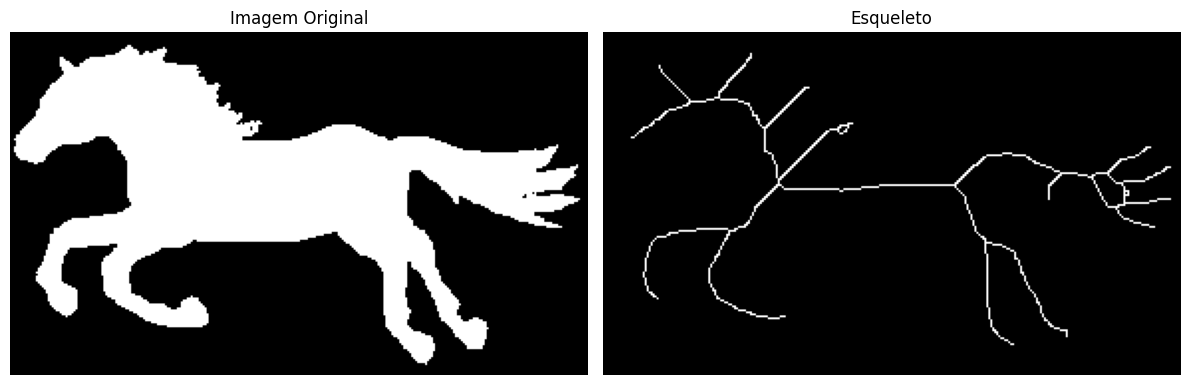

In [ ]:
#Esqueletonização.
def skeletonize(img):

    img = img.copy()
    
    while True:
        alterado = False

        pixels_para_remover = []
        for i in range(1, img.shape[0] - 1):
            for j in range(1, img.shape[1] - 1):
                if img[i, j] == 255:
                    vizinhos = [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
                                img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]
                    B = sum(v == 255 for v in vizinhos)
                    A = sum((vizinhos[k] == 0 and vizinhos[(k+1) % 8] == 255) for k in range(8))
                    
                    if (2 <= B <= 6) and (A == 1) and \
                       (vizinhos[0] == 0 or vizinhos[2] == 0 or vizinhos[4] == 0) and \
                       (vizinhos[2] == 0 or vizinhos[4] == 0 or vizinhos[6] == 0):
                        pixels_para_remover.append((i, j))

        for i, j in pixels_para_remover:
            img[i, j] = 0
            alterado = True

        pixels_para_remover = []
        for i in range(1, img.shape[0] - 1):
            for j in range(1, img.shape[1] - 1):
                if img[i, j] == 255:
                    vizinhos = [img[i-1, j], img[i-1, j+1], img[i, j+1], img[i+1, j+1],
                                img[i+1, j], img[i+1, j-1], img[i, j-1], img[i-1, j-1]]
                    B = sum(v == 255 for v in vizinhos)
                    A = sum((vizinhos[k] == 0 and vizinhos[(k+1) % 8] == 255) for k in range(8))

                    if (2 <= B <= 6) and (A == 1) and \
                       (vizinhos[0] == 0 or vizinhos[2] == 0 or vizinhos[6] == 0) and \
                       (vizinhos[0] == 0 or vizinhos[4] == 0 or vizinhos[6] == 0):
                        pixels_para_remover.append((i, j))

        for i, j in pixels_para_remover:
            img[i, j] = 0
            alterado = True

        if not alterado:
            break

    return img

imagem = cv2.imread("horse.png", cv2.IMREAD_GRAYSCALE)
imagem_binaria = (imagem == 0).astype(np.uint8) * 255
esqueleto = skeletonize(imagem_binaria)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(imagem_binaria, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Esqueleto")
plt.imshow(esqueleto, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


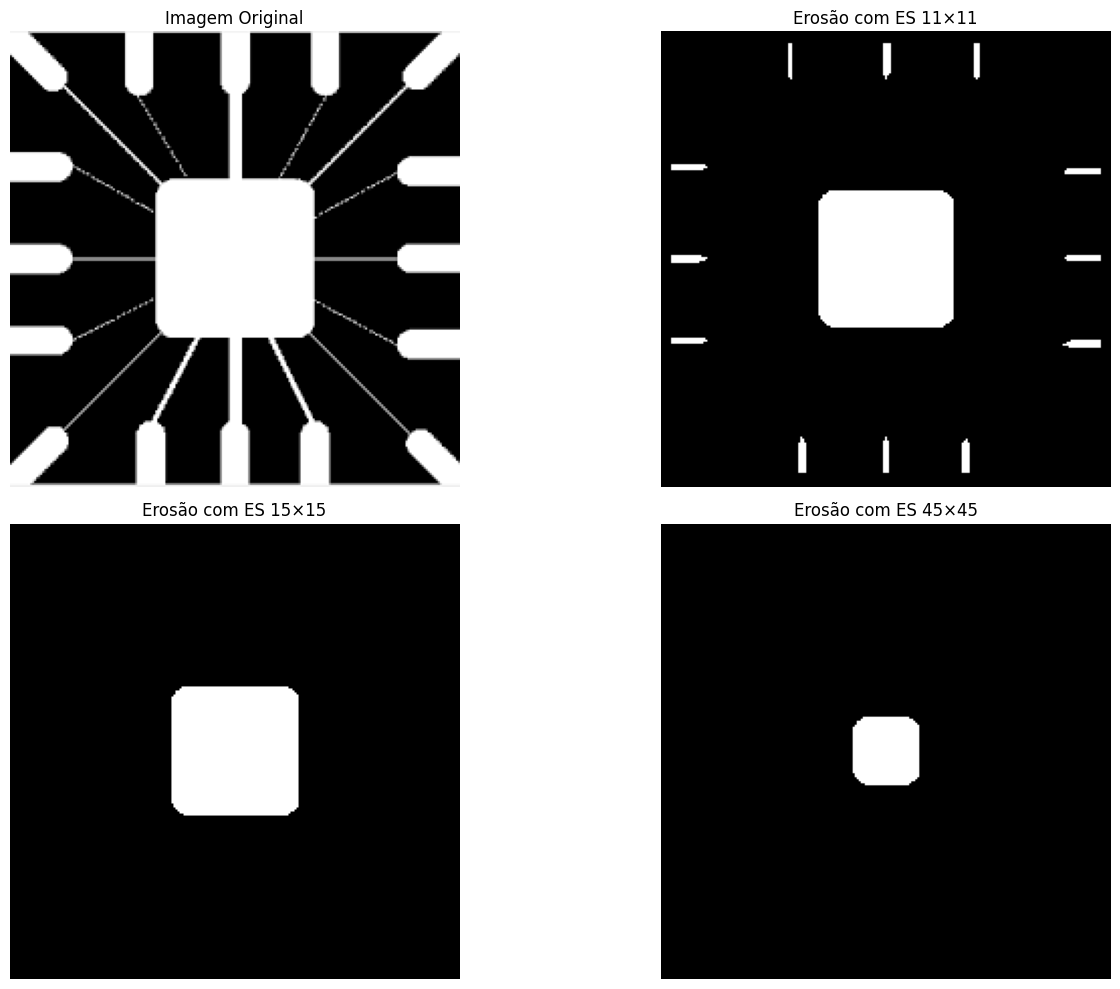

In [4]:
#erosao
def erosao(imagem, tamanho_es):
    
    altura, largura = imagem.shape
    margem = tamanho_es // 2
    
    imagem_erodida = np.zeros_like(imagem)
    
    for i in range(margem, altura - margem):
        for j in range(margem, largura - margem):
            regiao = imagem[i-margem:i+margem+1, j-margem:j+margem+1]
            imagem_erodida[i, j] = 255 if np.all(regiao == 255) else 0
    
    return imagem_erodida

imagem_original = cv2.imread('erosao.png', cv2.IMREAD_GRAYSCALE)

imagem_erodida_11 = erosao(imagem_original, 11)
imagem_erodida_15 = erosao(imagem_original, 15)
imagem_erodida_45 = erosao(imagem_original, 45)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(imagem_original, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(imagem_erodida_11, cmap='gray')
plt.title('Erosão com ES 11×11')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(imagem_erodida_15, cmap='gray')
plt.title('Erosão com ES 15×15')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(imagem_erodida_45, cmap='gray')
plt.title('Erosão com ES 45×45')
plt.axis('off')

plt.tight_layout()
plt.show()

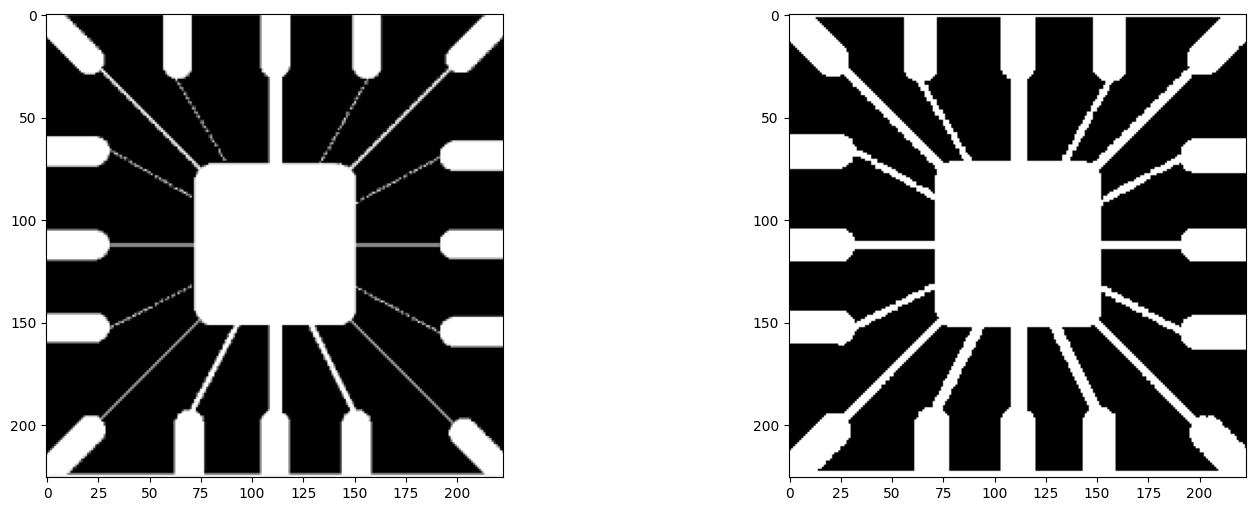

In [5]:
#dilatação

def dilatacao(imagem, elemento_estruturante):

    if set(np.unique(imagem)) - {0, 255}:
        raise ValueError("A imagem deve ser binária (0 e 255)")

    img = (imagem == 255).astype(np.uint8)
    if isinstance(elemento_estruturante, int):
        tamanho = elemento_estruturante
        kernel = np.ones((tamanho, tamanho), dtype=np.uint8)
    else:
        kernel = elemento_estruturante.astype(np.uint8)

    h, w = img.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    temp = np.zeros_like(img)

    for i in range(h):
        for j in range(w):
            regiao = padded[i:i + k_h, j:j + k_w]
            temp[i, j] = np.max(regiao * kernel)

    return temp * 255


img = cv2.imread('erosao.png', 0)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

kernel= np.ones((3,3), dtype=np.uint8)

resultado = dilatacao(img_bin, kernel)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(resultado, cmap='gray')
plt.tight_layout()
plt.show()

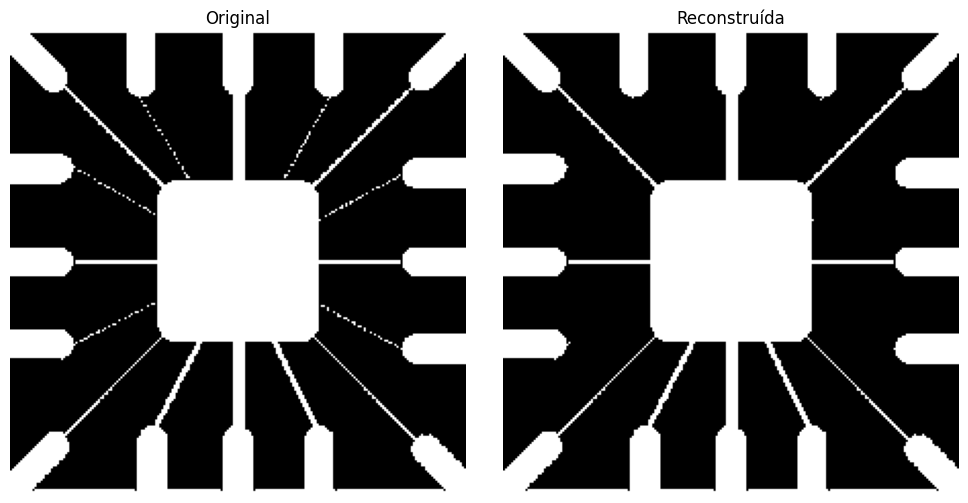

In [6]:
#reconstrução dilatação/erosao

def reconstrucao(imagem, tamanho_es=3, max_iter=100):

    kernel = np.ones((tamanho_es, tamanho_es), dtype=np.uint8)
    
    # 1. Reconstrução por erosão
    marcador = erosao(imagem, tamanho_es)
    rec_ero = marcador.copy()
    for _ in range(max_iter):
        dilatado = dilatacao(rec_ero, kernel)
        novo = np.minimum(dilatado, imagem)
        if np.array_equal(novo, rec_ero):
            break
        rec_ero = novo
    
    # 2. Reconstrução por dilatação
    marcador = dilatacao(rec_ero, kernel)
    rec_dil = marcador.copy()
    for _ in range(max_iter):
        erodido = erosao(rec_dil, tamanho_es)
        novo = np.maximum(erodido, rec_ero)
        if np.array_equal(novo, rec_dil):
            break
        rec_dil = novo
    
    return rec_dil


if __name__ == "__main__":

    img = cv2.imread('erosao.png', 0)
    _, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    resultado = reconstrucao(img_bin, tamanho_es=3)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_bin, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(resultado, cmap='gray')
    plt.title('Reconstruída')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

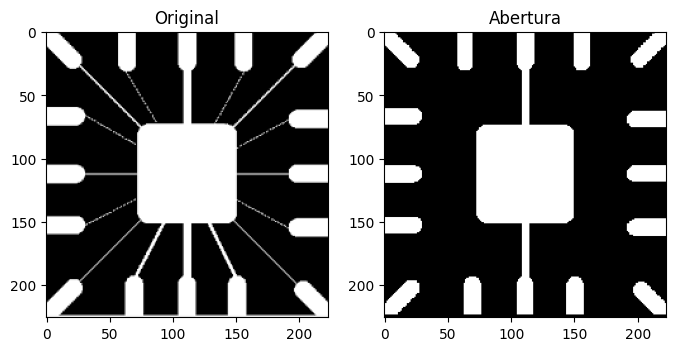

In [7]:
def abertura(imagem, elemento_estruturante, iteracoes=1):

    img = (imagem == 255).astype(np.uint8)
    kernel = elemento_estruturante.astype(np.uint8)
    
    h, w = img.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    for _ in range(iteracoes):

        padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
        temp_erode = np.zeros_like(img)
        
        for i in range(h):
            for j in range(w):
                regiao = padded[i:i+k_h, j:j+k_w]
                temp_erode[i,j] = 1 if np.all(regiao * kernel == kernel) else 0
        

        padded = np.pad(temp_erode, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
        temp_dilate = np.zeros_like(temp_erode)
        
        for i in range(h):
            for j in range(w):
                regiao = padded[i:i+k_h, j:j+k_w]
                temp_dilate[i,j] = 1 if np.any(regiao * kernel) else 0
        
        img = temp_dilate.copy()
    
    return img * 255


kernel = np.ones((5,5), dtype=np.uint8)
img = cv2.imread('erosao.png', 0)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

resultado = abertura(img, kernel, 1)

plt.figure(figsize=(8, 4))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(resultado, cmap='gray'), plt.title('Abertura')
plt.show()

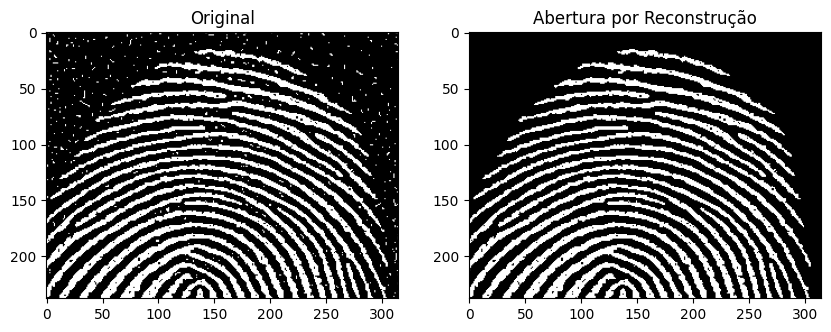

In [8]:
def reconstrucao_por_dilatacao(marcador, mascara, elemento_estruturante, max_iter=1000):

    reconstrucao = marcador.copy()
    anterior = np.zeros_like(reconstrucao)
    iteracao = 0
    
    while not np.array_equal(reconstrucao, anterior) and iteracao < max_iter:
        anterior = reconstrucao.copy()
        # Usa sua função de dilatação
        dilatado = dilatacao(reconstrucao, elemento_estruturante)
        # Condicionamento à máscara
        reconstrucao = np.minimum(dilatado, mascara)
        iteracao += 1
    return reconstrucao

def abertura_por_reconstrucao(imagem, tamanho_es, iteracoes_erosao=1):

    elemento_estruturante = np.ones((tamanho_es, tamanho_es), dtype=np.uint8)
    marcador = imagem.copy()
    for _ in range(iteracoes_erosao):
        marcador = erosao(marcador, tamanho_es)  
    resultado = reconstrucao_por_dilatacao(marcador, imagem, elemento_estruturante)
    return resultado


img = cv2.imread('digital.jpg', 0)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

resultado = abertura_por_reconstrucao(img_bin, tamanho_es=3, iteracoes_erosao=1)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_bin, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(resultado, cmap='gray'), plt.title('Abertura por Reconstrução')
plt.show()

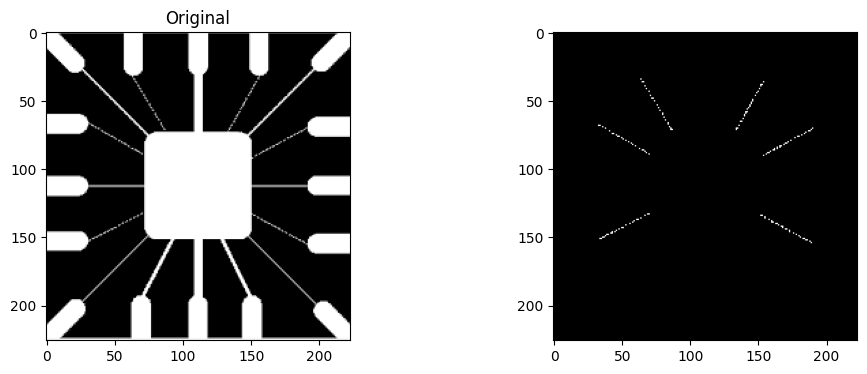

In [ ]:
#2.4 eliminação de elementos de borda.
def remover_elementos_borda(imagem_binaria):

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(imagem_binaria, connectivity=8)

    mascara = np.zeros_like(imagem_binaria, dtype=np.uint8)
 
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label] 
        toca_borda = (x == 0) or (y == 0) or (x + w == imagem_binaria.shape[1]) or (y + h == imagem_binaria.shape[0])
        if not toca_borda:
            mascara[labels == label] = 255
    return mascara

img = cv2.imread('erosao.png', 0)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img_sem_bordas = remover_elementos_borda(img_bin)

plt.figure(figsize=(12, 4))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(img_sem_bordas, cmap='gray'), plt.title('')
plt.show()